# This code will apply a recurrent neural network to predict the traffic demands of a sample metro network

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.__version__)

1.8.0


In [3]:
# Data input
data_1 = pd.read_csv('Data/1_Abilene_Network/abilene_traffic_matrices.csv')
data_1.index = data_1.timestamp
data_1 = pd.DataFrame(data_1.value)
data_1.head()

# Number of train, validation, test samples
n_train = 2246
n_validation = 561
n_test = 401
tm_vect_dim = 132

train_set = data_1.iloc[0:n_train*tm_vect_dim]
validation_set = data_1.iloc[(n_train)*tm_vect_dim:(n_train+n_validation)*tm_vect_dim]
test_set = data_1.iloc[(n_train+n_validation)*tm_vect_dim:(n_train+n_validation+n_test)*tm_vect_dim]

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296472 entries, 2004-03-01 00:00:00 to 2004-05-26 18:00:00
Data columns (total 1 columns):
value    296472 non-null float64
dtypes: float64(1)
memory usage: 4.5+ MB


In [5]:
validation_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74052 entries, 2004-05-26 18:00:00 to 2004-06-16 09:00:00
Data columns (total 1 columns):
value    74052 non-null float64
dtypes: float64(1)
memory usage: 1.1+ MB


In [6]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52932 entries, 2004-06-16 09:00:00 to 2004-06-31 23:00:00
Data columns (total 1 columns):
value    52932 non-null float64
dtypes: float64(1)
memory usage: 827.1+ KB


In [7]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
validation_scaled = scaler.transform(validation_set)
test_scaled = scaler.transform(test_set)

In [8]:
def next_batch(training_data,batch_size,steps,shift):
    
    # shift = 1
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-(steps+shift)) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+shift]).reshape(1,steps+shift)

    # return y_batch[:, :-shift].reshape(-shift, steps, 1), y_batch[:, shift:].reshape(-shift, steps, 1) 
    return y_batch[:, :-shift].reshape(-1, steps, 1), y_batch[:, shift:].reshape(-1, steps, 1) 

In [9]:
# Setting Up The RNN Model

In [10]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 6*132
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

shift = 132

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 100
# Size of the batch of data
batch_size = 1

In [11]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [17]:
# Also play around with GRUCell
#cell = tf.contrib.rnn.OutputProjectionWrapper(
#    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
#    output_size=num_outputs) 

# Also play around with GRUCell
n_neurons_per_layer = [100,100,100,1]
cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(num_units=n, activation=tf.nn.relu) for n in n_neurons_per_layer])
     

In [18]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [19]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [20]:
init = tf.global_variables_initializer()

In [21]:
saver = tf.train.Saver()

In [22]:
# TRAINING
MSE = []
with tf.Session() as sess:
    sess.run(init)
    shift = 132
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps,shift)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
        MSE.append(mse)
        if iteration % 100 == 0:
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./prediction_model/time_series_model")

(0, '\tMSE:', 0.00025533818)


In [23]:
# TEST
t_set = list(train_scaled[-num_time_steps:]) + list(test_scaled)
index_left = 0
index_right = num_time_steps
y_pred = []
with tf.Session() as sess:
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./prediction_model/time_series_model")
    for i in range(n_test): #10
        X_batch = np.array(t_set[index_left+(i*shift):index_right+(i*shift)]).reshape(1, num_time_steps, 1)
        y_pred_TEMP = sess.run(outputs, feed_dict={X: X_batch})        
        if i == 0:
            y_pred_2 = y_pred_TEMP[:, -shift:]
        else: 
            y_pred_2 = np.concatenate((y_pred_2, y_pred_TEMP[:, -shift:]), axis = 1)


INFO:tensorflow:Restoring parameters from ./prediction_model/time_series_model


In [24]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52932 entries, 2004-06-16 09:00:00 to 2004-06-31 23:00:00
Data columns (total 1 columns):
value    52932 non-null float64
dtypes: float64(1)
memory usage: 827.1+ KB


In [25]:
results = scaler.inverse_transform(np.array(y_pred_2).reshape(test_scaled.size ,1))

In [26]:
test_set['Generated'] = results

/home/seba/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
test_set.to_csv('Results/predizioni_test_dataframe.csv')

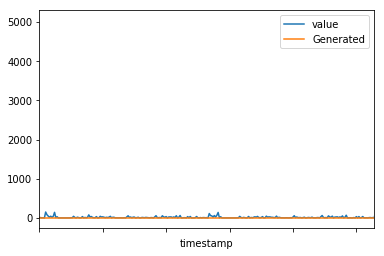

In [28]:
test_set.plot(xlim = [0, 132*2])